# Modelling intertidal elevation using tidal data

* **Products used:** 
[ls5_sr](https://explorer.digitalearth.africa/ls5_sr),
[ls7_sr](https://explorer.digitalearth.africa/ls7_sr),
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr)
* **Prerequisites:** For more information about the tidal modelling step of this analysis, refer to the [Tidal modelling notebook](../Frequently_used_code/Tidal_modelling.ipynb)

## Background
Intertidal environments support important ecological habitats (e.g. sandy beaches and shores, tidal flats and rocky shores and reefs), and provide many valuable benefits such as storm surge protection, carbon storage and natural resources for recreational and commercial use. 
However, intertidal zones are faced with increasing threats from coastal erosion, land reclamation (e.g. port construction), and sea level rise. 
Accurate elevation data describing the height and shape of the coastline is needed to help predict when and where these threats will have the greatest impact. 
However, this data is expensive and challenging to map across the entire intertidal zone of a continent the size of Africa.

### Digital Earth Africa use case
The rise and fall of the tide can be used to reveal the three-dimensional shape of the coastline by mapping the boundary betweeen water and land across a range of known tides (e.g. from low tide to high tide). 
Assuming that the land-water boundary is a line of constant height relative to mean sea level (MSL), elevations can be modelled for the area of coastline located between the lowest and highest observed tide. 

Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for modelling the 3D shape and structure of the intertidal zone at regional or national scale. 

Reference: [Bishop-Taylor et al. 2019](https://doi.org/10.1016/j.ecss.2019.03.006), the first 3D model of Australia's entire coastline: the National Intertidal Digital Elevation Model. 

## Description

In this example, we demonstrate a simplified version of the National Intertidal Digital Elevation Model (NIDEM) method that combines data from the Landsat 5, 7 and 8 satellites with tidal modelling, image compositing and spatial interpolation techniques. 
We first map the boundary between land and water from low to high tide, and use this information to generate smooth, continuous 3D elevation maps of the intertidal zone. 
The resulting data may assist in mapping the habitats of threatened coastal species, identifying areas of coastal erosion, planning for extreme events such as storm surges and flooding, and improving models of how sea level rise will affect the coastline. 
This worked example takes users through the code required to:

1.  Load in a cloud-free Landsat time series.
2.  Compute a water index (NDWI).
3.  Tag and sort satellite images by tide height.
4.  Create "summary" or composite images that show the distribution of land and water at discrete intervals of the tidal range (e.g. at low tide, high tide).
5.  Extract and visualise the topography of the intertidal zone as depth contours.
6.  Interpolate depth contours into a smooth, continuous Digital Elevation Model (DEM) of the intertidal zone.

***


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog

from datacube.utils.geometry import Geometry
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays, xr_rasterize
from deafrica_tools.plotting import display_map, map_shapefile, rgb
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.areaofinterest import define_area

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 97.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39541,Workers: 1
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 97.21 GiB
Comm: tcp://127.0.0.1:45167,Total threads: 15
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/42345/status,Memory: 97.21 GiB
Nanny: tcp://127.0.0.1:43513,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='Intertidal_elevation')

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `11.228`).
* `lon`: The central longitude to analyse (e.g. `-15.860`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2000', '2019') `)

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example generates an intertidal elevation model for an area off the coast of Guinea Bissau.

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat` and `lon`.


In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=11.228, lon=-15.860, buffer=0.02)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Set the range of dates for the analysis
time_range = ('2014', '2020')


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)


## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time specified.
For more infmation, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:


In [6]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load available data from all three Landsat satellites
landsat_ds = load_ard(dc=dc, 
                      products=['ls5_sr','ls7_sr','ls8_sr'],
                      output_crs=output_crs,
                      min_gooddata=0.5,
                      align=(15,15),
                      group_by='solar_day',
                      dask_chunks={},
                      **query)


/home/jovyan/.local/lib/python3.10/site-packages/deafrica_tools/datahandling.py:244: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_sr
    ls7_sr
    ls8_sr
Counting good quality pixels for each time step
Filtering to 174 out of 280 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 174 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [7]:
print(landsat_ds)


<xarray.Dataset>
Dimensions:      (time: 174, y: 149, x: 147)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-14T11:23:15.376568 ... 2020-12...
  * y            (y) float64 1.244e+06 1.244e+06 ... 1.239e+06 1.239e+06
  * x            (x) float64 4.039e+05 4.04e+05 4.04e+05 ... 4.083e+05 4.083e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [8]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf, da=landsat_ds, crs=landsat_ds.crs)
#Mask the dataset to the rasterised area of interest
landsat_ds = landsat_ds.where(aoi_raster == 1)

### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


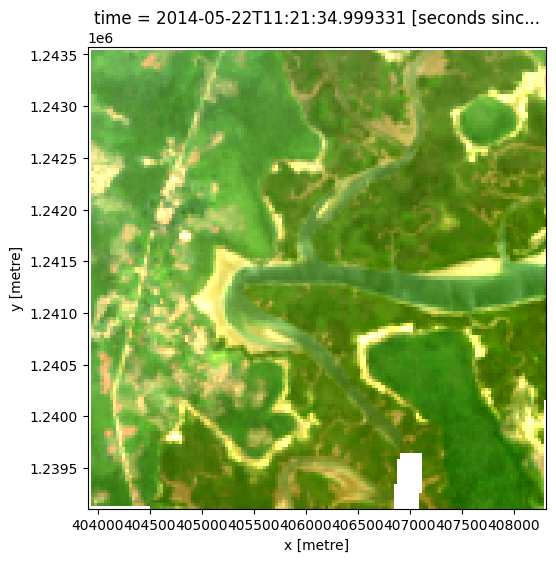

In [9]:
# Set the timesteps to visualise
timestep = 12

# Generate RGB plots at each timestep
rgb(landsat_ds, index=timestep)


## Compute Normalised Difference Water Index
To extract intertidal depth contours, we need to be able to seperate water from land in our study area. 
To do this, we can use our Landsat data to calculate a water index called the `Normalised Difference Water Index`, or NDWI. 
This index uses the ratio of green and near-infrared radiation to identify the presence of water. 
The formula is:

$$
\begin{aligned}
\text{NDWI} &= \frac{(\text{Green} - \text{NIR})}{(\text{Green} + \text{NIR})}
\end{aligned}
$$

where `Green` is the green band and `NIR` is the near-infrared band. 

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

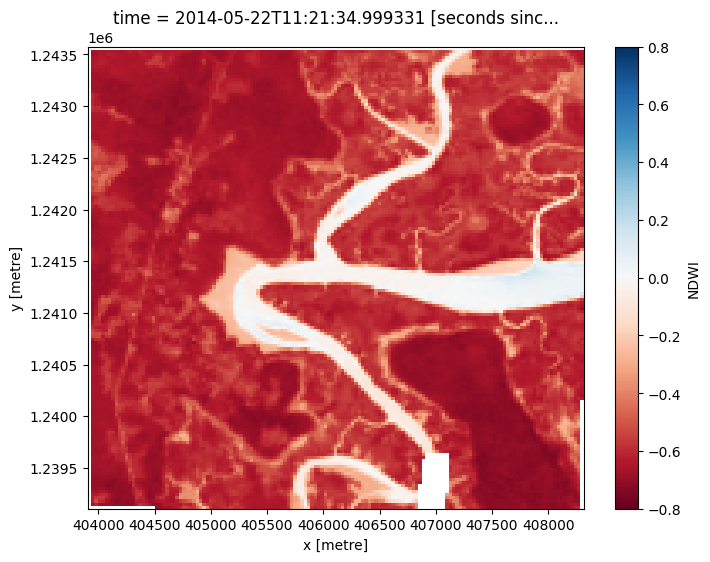

In [10]:
# Calculate the water index
landsat_ds = calculate_indices(landsat_ds, index='NDWI', 
                               satellite_mission='ls')

# Plot the resulting image for the same timestep selected above
landsat_ds.NDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          vmin=-0.8,
                                          vmax=0.8)
plt.show()


How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to calculate the height of the tide at the exact moment each Landsat image was acquired. 
This will allow us to built a sorted time series of images taken at low tide to high tide, which we will use to generate the intertidal elevation model.

The `tidal_tag` function below uses the [OTPS TPXO8 tidal model](https://www.tpxo.net/global/tpxo8-atlas) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_m` attribute in our dataset (for more information about this function, refer to the [Tidal modelling notebook](../Frequently_used_code/Tidal_modelling.ipynb)). 

> **Note:** this function can only model tides correctly if the centre of your study area is located over water. 
If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=11.228, tidepost_lon=-15.860`).

In [11]:
# Calculate tides for each timestep in the satellite dataset
landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_m` variable
print(landsat_ds)


Setting tide modelling location from dataset centroid: -15.86, 11.23
Modelling tides using FES2014 tidal model
<xarray.Dataset>
Dimensions:      (time: 174, y: 149, x: 147)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-14T11:23:15.376568 ... 2020-12...
  * y            (y) float64 1.244e+06 1.244e+06 ... 1.239e+06 1.239e+06
  * x            (x) float64 4.039e+05 4.04e+05 4.04e+05 ... 4.083e+05 4.083e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    NDWI         (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    tide_m       (time) float64 0.5195 0.14 1.126 ... -0.9949 -1.165 1.798
Attr

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series: 

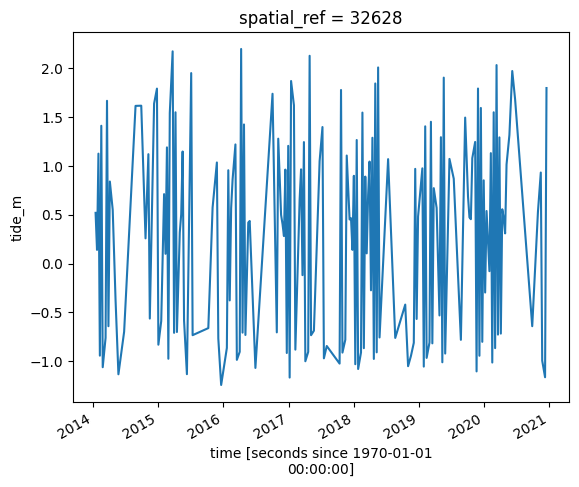

In [12]:
# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_m.plot()
plt.show()

## Create water index summary images from low to high tide

Using these tide heights, we can sort our Landsat dataset by tide height to reveal which parts of the landscape are inundated or exposed from low to high tide. 

Individual remote sensing images can be affected by noise, including clouds, sunglint and poor water quality conditions (e.g. sediment). 
To produce cleaner images that can be compared more easily between tidal stages, we can create 'summary' images or composites that combine multiple images into one image to reveal the 'typical' or median appearance of the landscape at different tidal stages. 
In this case, we use the median as the summary statistic because it prevents strong outliers (like stray clouds) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images, sort by tide and categorise each image into 9 discrete tidal intervals, ranging from the lowest (tidal interval 1) to the highest tides observed by Landsat (tidal interval 9). 
For more information on this method, refer to [Sagar et al. 2018](https://www.sciencedirect.com/science/article/pii/S0034425717301591).

In [13]:
# Sort every image by tide height
landsat_ds = landsat_ds.sortby('tide_m')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(landsat_ds.tide_m.min(),
                          landsat_ds.tide_m.max(),
                          num=10)
tide_intervals = pd.cut(landsat_ds.tide_m,
                        bins=binInterval,
                        labels=range(1, 10),
                        include_lowest=True)

# Add interval to dataset
landsat_ds['tide_interval'] = xr.DataArray(tide_intervals,
                                           [('time', landsat_ds.time.data)])

print(landsat_ds)


<xarray.Dataset>
Dimensions:        (time: 174, y: 149, x: 147)
Coordinates:
  * time           (time) datetime64[ns] 2015-12-19T11:22:13.664612 ... 2016-...
  * y              (y) float64 1.244e+06 1.244e+06 ... 1.239e+06 1.239e+06
  * x              (x) float64 4.039e+05 4.04e+05 ... 4.083e+05 4.083e+05
    spatial_ref    int32 32628
Data variables:
    red            (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    green          (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    blue           (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    nir            (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    NDWI           (time, y, x) float32 dask.array<chunksize=(1, 149, 147), meta=np.ndarray>
    tide_m         (time) float64 -1.244 -1.168 -1.165 ... 2.129 2.174 2.198
    tide_interval  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 8 9 9 9 9 9 9 9 9 9 9
Attributes:
    crs:    

We can plot the boundaries between the nine tidal intervals on the same plot we generated earlier:

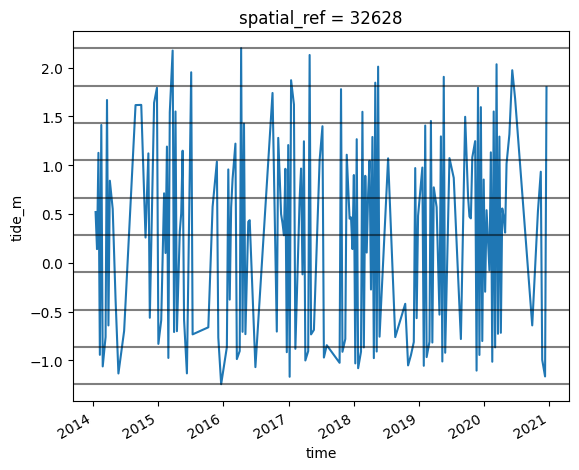

In [14]:
landsat_ds.sortby('time').tide_m.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)
    

Now that we have a dataset where each image is classified into a discrete range of the tide, we can combine our images into a set of nine individual images that show where land and water is located from low to high tide. 
**This step can take several minutes to process.**

> **Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

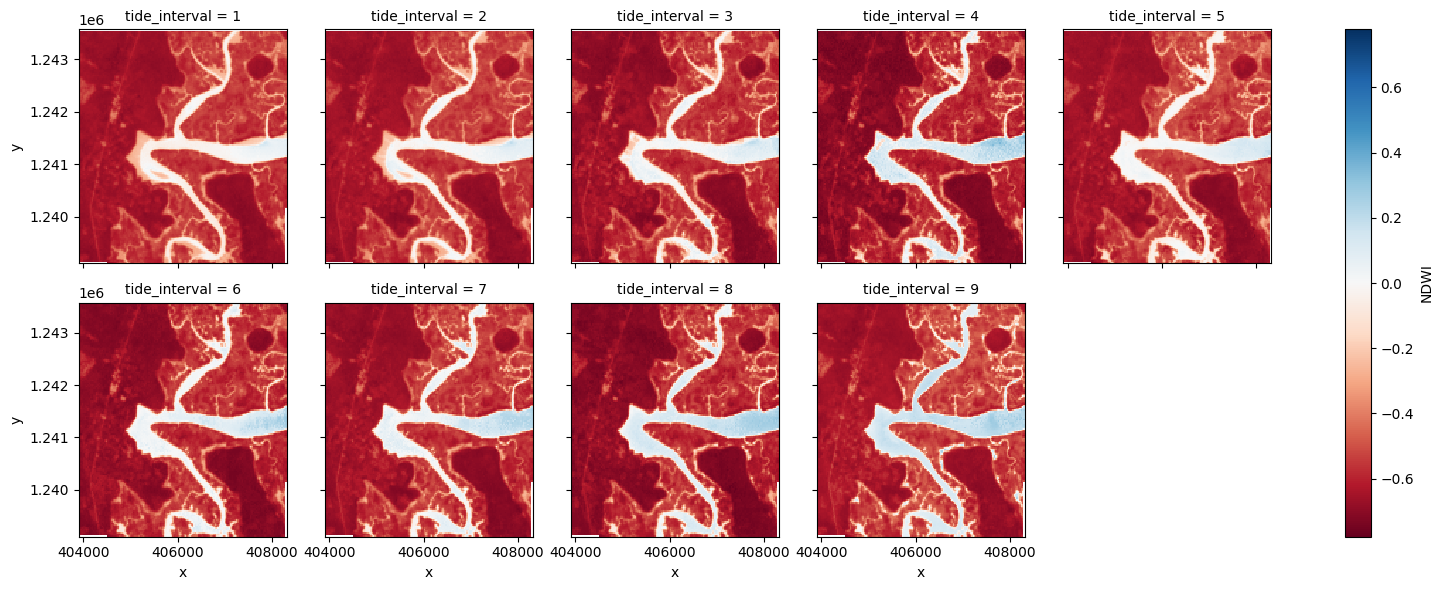

In [15]:
# For each interval, compute the median water index and tide height value
landsat_intervals = (landsat_ds[['tide_interval', 'NDWI', 'tide_m']]
                     .compute()
                     .groupby('tide_interval')
                     .median(dim='time'))

# Plot the resulting set of tidal intervals
landsat_intervals.NDWI.plot(col='tide_interval', col_wrap=5, cmap='RdBu')
plt.show()


The plot above should make it clear how the shape and structure of the coastline changes significantly from low to high tide as low-lying tidal flats are quickly inundated by increasing water levels.

## Extract depth contours from imagery
We now want to extract an accurate boundary between land and water for each of the tidal intervals above. 
The code below identifies the depth contours based on the boundary between land and water by tracing a line along pixels with a water index value of `0` (the boundary between land and water water index values). 
It returns a `geopandas.GeoDataFrame` with one depth contour for each tidal interval that is labelled with tide heights in metres relative to Mean Sea Level.


Operating in single z-value, multiple arrays mode


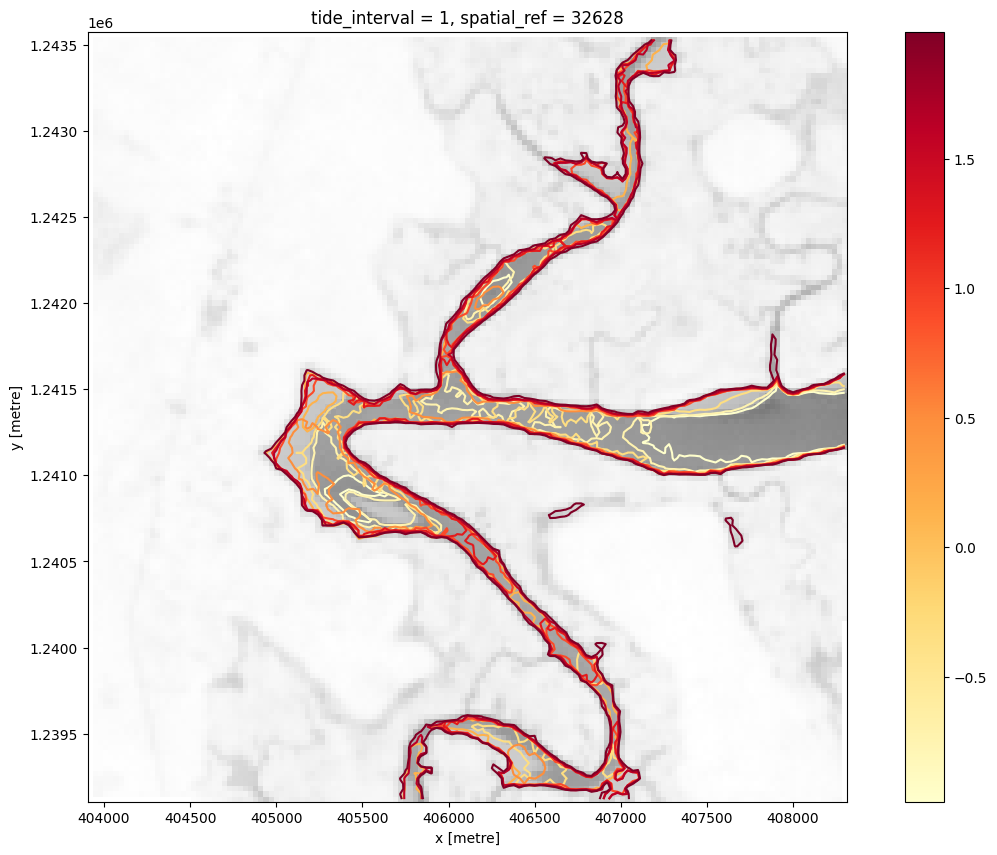

In [16]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_m.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_intervals.NDWI,
                                 z_values=0,
                                 crs=landsat_ds.geobox.crs,
                                 attribute_df=attribute_df,
                                 min_vertices=20,
                                 dim='tide_interval')

# Plot output shapefile over the top of the first tidal interval water index
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
landsat_intervals.NDWI.sel(tide_interval=1).plot(ax=ax, 
                                                 cmap='Greys', 
                                                 add_colorbar=False)
contours_gdf.plot(ax=ax, column='tide_m', cmap='YlOrRd', legend=True)
plt.show()


The above plot is a basic visualisation of the depth contours returned by the `subpixel_contours` function. 
**Deeper contours (in m relative to Mean Sea Level) are coloured in yellow; more shallow contours are coloured in red.**
Now have the shapefile, we can use a more complex function to make an interactive plot for viewing the topography of the intertidal zone.

### Plot interactive map of depth contours coloured by time
The next cell provides an interactive map with an overlay of the depth contours identified in the previous cell. 
Run it to view the map.

Zoom in to the map below to explore the resulting set of depth contours. 
Using this data, we can easily identify areas of the coastline which are only exposed in the lowest of tides, or other areas that are only covered by water during high tides.

In [17]:
map_shapefile(gdf=contours_gdf, attribute='tide_m', continuous=True)

Label(value='')

Map(center=[11.227993219597318, -15.855455977368928], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Interpolate contours into a Digital Elevation Model (DEM)

While the contours above provide valuable information about the topography of the intertidal zone, we can extract additional information about the 3D structure of the coastline by converting them into an elevation raster (i.e. a Digital Elevation Model or DEM).

In the cell below, we convert the shapefile above into an array of points with X, Y and Z coordinates, where the Z coordinate is the point's elevation relative to Mean Sea Level. 
We then use these XYZ points to interpolate smooth, continuous elevations across the intertidal zone using linear interpolation.

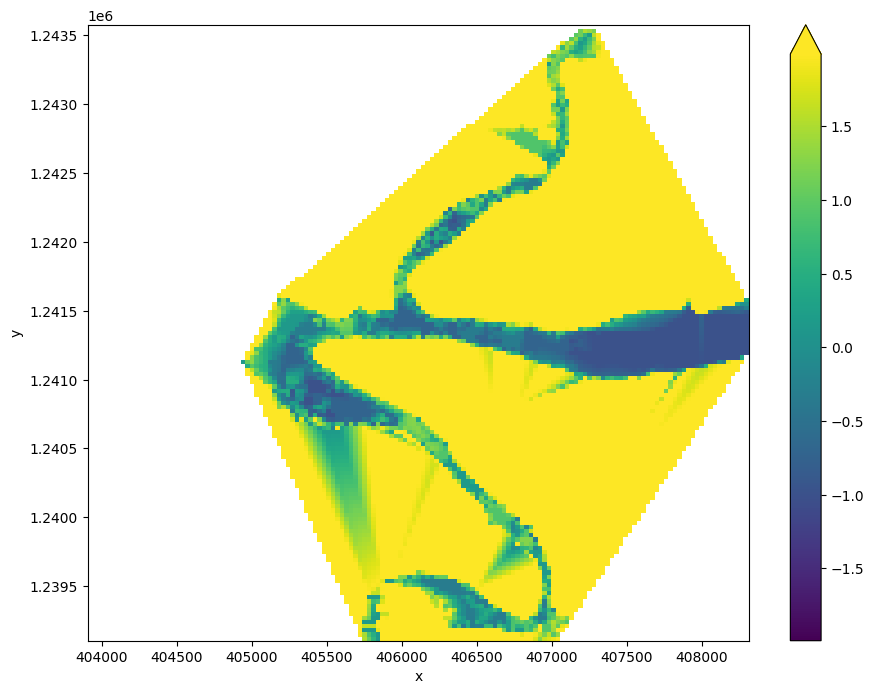

In [18]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=landsat_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2])

# Plot the output
intertidal_dem.plot(cmap='viridis', size=8, robust=True)
plt.show()


You can see in the output above that our interpolation results are very messy. 
This is because the interpolation extends across areas of our study area that are not affected by tides (e.g. areas of water located beyond the lowest observed tide, and on land). 
To clean up the data, we can restrict the DEM to only the area between the lowest and highest observed tides:

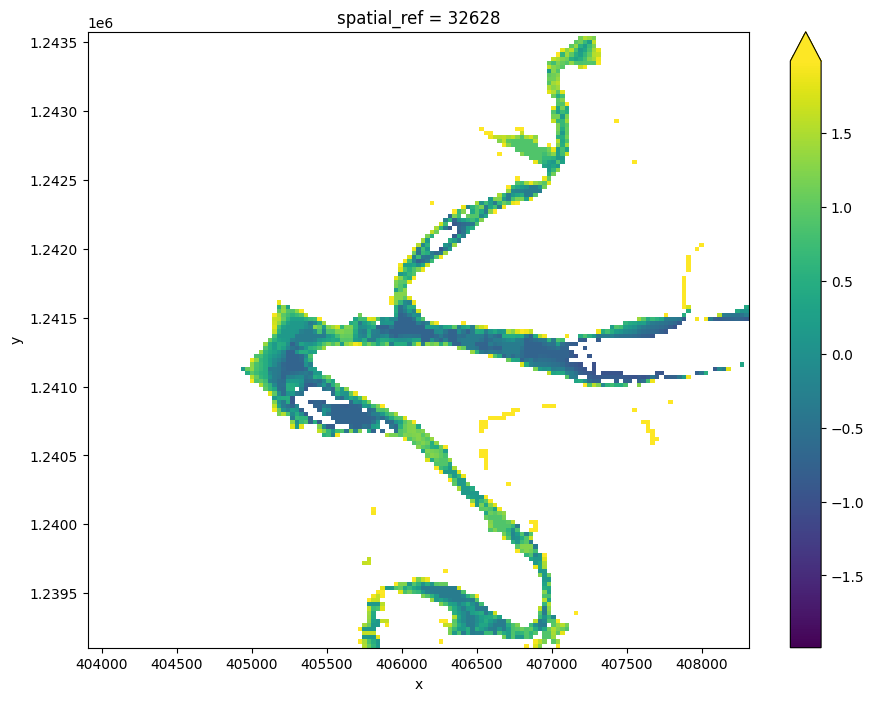

In [19]:
# Identify areas that are always wet (e.g. below low tide), or always dry
above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8, robust=True)
plt.show()


## Export intertidal DEM as a GeoTIFF
As a final step, we can take the intertidal DEM we created and export it as a GeoTIFF that can be loaded in GIS software like QGIS or ArcMap (to download the dataset from the Sandbox, locate it in the file browser to the left, right click on the file, and select "Download").

In [20]:
# Export as a GeoTIFF
write_cog(intertidal_dem_clean,
          fname='intertidal_dem.tif',
          overwrite=True)


PosixPath('intertidal_dem.tif')

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `lat` and `lon`) and rerun the analysis. 

If you're going to change the location, you'll need to make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DEAfrica Explorer](https://explorer.digitalearth.africa/products) (use the drop-down menu to view all Landsat products). 

### National Intertidal Digital Elevation Model
For more information about the science behind this notebook, please refer to the scientific article outlining the application of this approach to the entire Australian coastline: [Bishop-Taylor et al. 2019 Between the tides: Modelling the elevation of Australia's exposed intertidal zone at continental scale](https://doi.org/10.1016/j.ecss.2019.03.006).

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [21]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-09-19'